In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score



In [3]:
#create 64 60*60 squares from a 480*480 image chess board
import cv2
import os

# Base directory paths
base_dir = "chess_images/board_and_fen/"
output_dir = "chess_images/squares/"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to resize the image to 480x480 if needed
def resize_image_if_needed(image):
    # Check if the image is not 480x480
    if image.shape[0] != 480 or image.shape[1] != 480:
        # print(f"Resizing image to 480x480...")
        image = cv2.resize(image, (480, 480))
    return image

# Function to divide the board into 8x8 squares
def split_chessboard(image_path, output_subfolder, board_name):
    image = cv2.imread(image_path)
    image = resize_image_if_needed(image)  # Ensure the image is 480x480
    step = 60  # Each square is 60x60
    # Create a specific folder for each board inside the respective subfolder
    board_output_dir = os.path.join(output_subfolder, board_name)
    os.makedirs(board_output_dir, exist_ok=True)
    for i in range(8):
        for j in range(8):
            square = image[i * step:(i + 1) * step, j * step:(j + 1) * step]
            square_name = f"r{i}_c{j}.jpg"
            cv2.imwrite(os.path.join(board_output_dir, square_name), square)

# Process all images in all subfolders
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):  # Ensure it's a directory
        # Create corresponding output subfolder
        output_subfolder = os.path.join(output_dir, subfolder)
        os.makedirs(output_subfolder, exist_ok=True)
        for image_file in os.listdir(subfolder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                board_name = os.path.splitext(image_file)[0]
                split_chessboard(os.path.join(subfolder_path, image_file), output_subfolder, board_name)


In [ ]:
#write a bw_fen by reading fen for each image

import os

def fen_to_bw(fen):
    # Mapping of pieces to "b" (black) and "w" (white)
    piece_map = {
        'p': 'b', 'r': 'b', 'n': 'b', 'b': 'b', 'q': 'b', 'k': 'b',
        'P': 'w', 'R': 'w', 'N': 'w', 'B': 'w', 'Q': 'w', 'K': 'w',
    }

    # Split the FEN string to focus only on the board layout (first part)
    board, *_ = fen.split(' ')

    # Replace pieces in the board layout with 'b', 'w', or retain numbers
    bw_board = []
    for char in board:
        if char in piece_map:
            bw_board.append(piece_map[char])
        elif char.isdigit():  # Keep numbers representing empty squares
            bw_board.append(char)
        elif char == '/':  # Keep row separators
            bw_board.append('/')
    
    # Join the converted board layout into the final string
    return ''.join(bw_board)

def add_bw_board_fen(base_dir):
    # Correct path to where the numbered folders are stored
    numbered_folders_dir = os.path.join(base_dir, "board_and_fen")
    
    for folder_name in os.listdir(numbered_folders_dir):
        folder_path = os.path.join(numbered_folders_dir, folder_name)
        if os.path.isdir(folder_path):  # Ensure it's a folder
            fen_file = os.path.join(folder_path, 'board.fen')
            bw_fen_file = os.path.join(folder_path, 'bw_board.fen')
            
            if os.path.exists(fen_file):
                # Read the original FEN file
                with open(fen_file, 'r') as file:
                    original_fen = file.read().strip()
                
                # Convert to black/white FEN
                bw_fen = fen_to_bw(original_fen)
                
                # Write the black/white FEN to a new file
                with open(bw_fen_file, 'w') as file:
                    file.write(bw_fen)
                print(f"Created: {bw_fen_file}")

# Set the base directory for the chess images
base_dir = "chess_images"  # Adjust if your notebook is in a different location

# Add the bw_board.fen file to each folder
add_bw_board_fen(base_dir)


In [4]:
#labeling each square by looking at bw_fen and write in csv for each square

import os
import csv

# Paths
base_dir = "chess_images/board_and_fen/"
output_dir = "chess_images/labels/"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to parse FEN and generate labels
def parse_fen(fen, output_subfolder, board_name):
    rows = fen.strip().split("/")
    for row_idx, row in enumerate(rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                # Empty squares
                for _ in range(int(char)):
                    square_name = f"r{row_idx}_c{col_idx}.csv"
                    square_output_dir = os.path.join(output_subfolder, board_name)
                    os.makedirs(square_output_dir, exist_ok=True)
                    with open(os.path.join(square_output_dir, square_name), "w", newline="") as csvfile:
                        writer = csv.writer(csvfile)
                        writer.writerow(["label"])
                        writer.writerow(["none"])  # Empty square
                    col_idx += 1
            else:
                # Black ('b') or White ('w') piece
                square_name = f"r{row_idx}_c{col_idx}.csv"
                label = "black" if char == "b" else "white"
                square_output_dir = os.path.join(output_subfolder, board_name)
                os.makedirs(square_output_dir, exist_ok=True)
                with open(os.path.join(square_output_dir, square_name), "w", newline="") as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(["label"])
                    writer.writerow([label])
                col_idx += 1

# Process each subfolder
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):  # Ensure it's a directory
        output_subfolder = os.path.join(output_dir, subfolder)
        os.makedirs(output_subfolder, exist_ok=True)
        for file in os.listdir(subfolder_path):
            if file == "bw_board.fen":
                with open(os.path.join(subfolder_path, file), "r") as fen_file:
                    fen = fen_file.read()
                # Parse the FEN and generate labels for each board
                board_name = os.path.splitext(file)[0]
                parse_fen(fen, output_subfolder, board_name)



In [4]:
import os
import cv2
import csv
import numpy as np
import re

# Base directory paths
squares_dir = "chess_images/squares/"
labels_dir = "chess_images/labels/"
output_file = "chess_images/prepared_data/svm_data.npy"  # Final dataset file

# Function to extract image features (flattened grayscale pixel values)
def extract_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (60, 60))  # Ensure uniform size
    return image.flatten()  # Flatten the image into a feature vector

# Function to load labels from a CSV file
def load_label(labels_dir, subfolder, row, col):
    label_path = os.path.join(labels_dir, subfolder, "bw_board", f"r{row}_c{col}.csv")
    try:
        with open(label_path, "r") as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            return next(reader)[0]  # Return the label ("white", "black", or "none")
    except FileNotFoundError:
        print(f"Label not found: {label_path}")
        return "none"

# Function to parse row and column from filenames
def parse_row_col(filename):
    match = re.match(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        raise ValueError(f"Filename format error: {filename}")

# Prepare the dataset
features = []
labels = []

# Loop through all folders and boards
for subfolder in os.listdir(squares_dir):
    subfolder_path = os.path.join(squares_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for board_folder in os.listdir(subfolder_path):
            board_path = os.path.join(subfolder_path, board_folder)
            if os.path.isdir(board_path):
                for square_image in os.listdir(board_path):
                    if square_image.endswith(".jpg"):
                        image_path = os.path.join(board_path, square_image)
                        
                        try:
                            # Parse row and column from the filename
                            row, col = parse_row_col(square_image)
                        except ValueError as e:
                            print(e)
                            continue
                        
                        # Extract features and load labels
                        features.append(extract_features(image_path))
                        labels.append(load_label(labels_dir, subfolder, row, col))

# Convert features and labels into numpy arrays for SVM training
X = np.array(features)

label_mapping = {"white": 1, "black": -1, "none": 0}
y = np.array([label_mapping[label] for label in labels])

# Save the dataset as a .npy file
np.save(output_file, {"features": X, "labels": y})

print(f"Data preparation complete. Saved to {output_file}.")


FileNotFoundError: [Errno 2] No such file or directory: 'chess_images/prepared_data/svm_data.npy'

In [3]:
import numpy as np

# Load the saved data
data = np.load("chess_images/prepared_data/hog_svm_data.npy", allow_pickle=True).item()

# Extract features and labels
features = data["features"]
labels = data["labels"]

# Display the shapes of the datasets
print(f"Number of samples: {features.shape[0]}")
print(f"Feature vector size (per sample): {features.shape[1]}")
print(f"Number of labels: {len(labels)}")

# Display a few samples
print("\nSample features (first 3):")
print(features[:3])  # Print the first three feature vectors

print("\nSample labels (first 3):")
print(labels[:3])  # Print the first three labels


Number of samples: 17600
Feature vector size (per sample): 1296
Number of labels: 17600

Sample features (first 3):
[[0.45375777 0.0822181  0.13528498 ... 0.1100283  0.         0.        ]
 [0.44317712 0.06178785 0.03534978 ... 0.21279086 0.18196391 0.06203866]
 [0.43382379 0.21830514 0.15788306 ... 0.14637069 0.         0.06495047]]

Sample labels (first 3):
[ 0  0 -1]


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [17]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', C=1.0)  # Adjust `C` and kernel as needed
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [18]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6529794692038057
Classification Report:
               precision    recall  f1-score   support

          -1       0.50      0.41      0.45      1024
           0       0.73      0.96      0.83      1894
           1       0.57      0.35      0.43      1076

    accuracy                           0.65      3994
   macro avg       0.60      0.57      0.57      3994
weighted avg       0.63      0.65      0.62      3994



In [5]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import os
import csv
import re

# Base directory paths
squares_dir = "chess_images/squares/"
labels_dir = "chess_images/labels/"
output_file = "chess_images/prepared_data/hog_svm_data.npy"  # Final dataset file

def extract_hog_features(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to a consistent size (60x60)
    image = cv2.resize(image, (60, 60))

    # Compute HOG features (no need for multichannel argument)
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True)
    
    # Return the feature descriptor (fd)
    return fd

# Function to load labels from a CSV file
def load_label(labels_dir, subfolder, row, col):
    label_path = os.path.join(labels_dir, subfolder, "bw_board", f"r{row}_c{col}.csv")
    try:
        with open(label_path, "r") as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            return next(reader)[0]  # Return the label ("white", "black", or "none")
    except FileNotFoundError:
        print(f"Label not found: {label_path}")
        return "none"

# Function to parse row and column from filenames
def parse_row_col(filename):
    match = re.match(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        raise ValueError(f"Filename format error: {filename}")

# Prepare the dataset
features = []
labels = []

# Loop through all folders and boards
for subfolder in os.listdir(squares_dir):
    subfolder_path = os.path.join(squares_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for board_folder in os.listdir(subfolder_path):
            board_path = os.path.join(subfolder_path, board_folder)
            if os.path.isdir(board_path):
                for square_image in os.listdir(board_path):
                    if square_image.endswith(".jpg"):
                        image_path = os.path.join(board_path, square_image)
                        
                        try:
                            # Parse row and column from the filename
                            row, col = parse_row_col(square_image)
                        except ValueError as e:
                            print(e)
                            continue
                        
                        # Extract HOG features and load labels
                        features.append(extract_hog_features(image_path))
                        labels.append(load_label(labels_dir, subfolder, row, col))

# Convert features and labels into numpy arrays for SVM training
X = np.array(features)

label_mapping = {"white": 1, "black": -1, "none": 0}
y = np.array([label_mapping[label] for label in labels])

# Save the dataset as a .npy file
np.save(output_file, {"features": X, "labels": y})

print(f"Data preparation complete. Saved to {output_file}.")


Data preparation complete. Saved to chess_images/prepared_data/hog_svm_data.npy.


In [11]:
#K Fold
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load dataset
data = np.load("chess_images/prepared_data/hog_svm_data.npy", allow_pickle=True).item()
X, y = data["features"], data["labels"]

# Define models
models = {
    # "SVM": SVC(kernel="linear"),
    # "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std Dev = {scores.std():.4f}")


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [11]:
#K Fold and Save Model
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load dataset
data = np.load("chess_images/prepared_data/hog_svm_data.npy", allow_pickle=True).item()
X, y = data["features"], data["labels"]

# Define models
models = {
    "SVM": SVC(kernel="linear"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model and save the best one
best_model = None
best_score = 0

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    mean_score = scores.mean()
    print(f"{name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {scores.std():.4f}")

    # Train model on the full dataset before saving
    model.fit(X, y)
    model_path = f"chess_images/prepared_data/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

    # Track the best model
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Save the best model separately
best_model_path = "chess_images/prepared_data/best_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Best model saved to {best_model_path}")


SVM: Mean Accuracy = 0.9756, Std Dev = 0.0033
Saved SVM model to chess_images/prepared_data/svm_model.pkl
Random Forest: Mean Accuracy = 0.9884, Std Dev = 0.0046
Saved Random Forest model to chess_images/prepared_data/random_forest_model.pkl
Best model saved to chess_images/prepared_data/best_model.pkl


In [2]:
#loading the model and testing input as 480*480 image and output as bw_fen file

import joblib
import cv2
import numpy as np
from skimage.feature import hog

# Load the trained model
model = joblib.load('chess_images/prepared_data/svm_model.pkl')

def extract_hog_features(image):
    image = cv2.resize(image, (60, 60))
    fd, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=True)
    return fd

def split_and_predict_fen(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (480, 480))
    step = 60
    label_mapping_inverse = {1: "w", -1: "b", 0: "1"}  # FEN compatible labels
    predictions = []

    for row in range(8):
        row_data = []
        for col in range(8):
            square = image[row * step:(row + 1) * step, col * step:(col + 1) * step]
            features = extract_hog_features(square)
            prediction = model.predict([features])[0]
            row_data.append(label_mapping_inverse[prediction])
        # Convert row data to FEN row format
        fen_row = ''.join(row_data)
        # Consolidate empty squares into numbers
        compact_fen_row = ''
        count = 0
        for char in fen_row:
            if char == '1':
                count += 1
            else:
                if count > 0:
                    compact_fen_row += str(count)
                    count = 0
                compact_fen_row += char
        if count > 0:
            compact_fen_row += str(count)
        predictions.append(compact_fen_row)

    # Join rows with '/' for the final FEN
    fen_result = '/'.join(predictions)
    return fen_result

# Example usage:
image_path = 'chess_images/test1.jpg'
fen_output = split_and_predict_fen(image_path)
print("Generated FEN:", fen_output)

# Optionally, save the FEN to a file
with open("generated_bw_fen.fen", "w") as file:
    file.write(fen_output)


Generated FEN: 2bwbw2/ww4wb/wwbwwwbw/3bbb2/3wbb2/w6b/bbbbbbbb/8


In [5]:
#loading the model and testing input as 480*480 image and output as bw_fen file 2222222222222222
import pandas as pd
import joblib
import cv2
import numpy as np
from skimage.feature import hog

# Load the trained model
model = joblib.load('chess_images/prepared_data/lightgbm_model.pkl')

def extract_hog_features(image):
    image = cv2.resize(image, (60, 60))
    fd, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=True)
    
    # Convert features to a DataFrame with column names matching training data
    feature_names = [f'feature_{i}' for i in range(len(fd))]  # Create feature names
    return pd.DataFrame([fd], columns=feature_names)  # Wrap in DataFrame

def split_and_predict_fen(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (480, 480))
    step = 60
    label_mapping_inverse = {1: "w", -1: "b", 0: "1"}  # FEN compatible labels
    predictions = []

    for row in range(8):
        row_data = []
        for col in range(8):
            square = image[row * step:(row + 1) * step, col * step:(col + 1) * step]
            features_df = extract_hog_features(square)  # Get features as DataFrame
            prediction = model.predict(features_df)[0]  # Pass DataFrame instead of list
            row_data.append(label_mapping_inverse[prediction])
        # Convert row data to FEN row format
        fen_row = ''.join(row_data)
        # Consolidate empty squares into numbers
        compact_fen_row = ''
        count = 0
        for char in fen_row:
            if char == '1':
                count += 1
            else:
                if count > 0:
                    compact_fen_row += str(count)
                    count = 0
                compact_fen_row += char
        if count > 0:
            compact_fen_row += str(count)
        predictions.append(compact_fen_row)

    # Join rows with '/' for the final FEN
    fen_result = '/'.join(predictions)
    return fen_result

# Example usage:
image_path = 'chess_images/chess232.jpg'
fen_output = split_and_predict_fen(image_path)
print("Generated FEN:", fen_output)

# Optionally, save the FEN to a file
with open("generated_bw_fen.fen", "w") as file:
    file.write(fen_output)


Generated FEN: b2b1bb1/bbbb1bbb/2bb1bb1/4b3/4ww2/2ww1w2/www1w1ww/w1ww1ww1


In [2]:
import numpy as np

# Adjust the path to match where you uploaded the file
data_path = 'chess_images/prepared_data/hog_svm_data.npy'
data = np.load(data_path, allow_pickle=True).item()

X = data["features"]
y = data["labels"]


In [1]:
import numpy as np

# Load dataset
data = np.load("chess_images/prepared_data/hog_svm_data.npy", allow_pickle=True).item()
y = data["labels"]

# Count occurrences of each class
unique, counts = np.unique(y, return_counts=True)

# Print results
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")


Label -1: 32000 samples
Label 0: 64000 samples
Label 1: 32000 samples


In [5]:
#data augmentation for -1 and 1 labels

from collections import Counter
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# Adjust the path to the file location in your Google Drive
data_path = 'chess_images/prepared_data/hog_svm_data.npy'

# Load the prepared data
data = np.load(data_path, allow_pickle=True).item()


# Extract features and labels
X = data["features"]
y = data["labels"]


def augment_features(X, y, target_label, num_samples):
    augmented_X, augmented_y = [], []
    for i, (features, label) in enumerate(zip(X, y)):
        if label == target_label:
            for _ in range(num_samples):
                # Add small noise to features
                noisy_features = features + np.random.normal(0, 0.01, size=features.shape)
                augmented_X.append(noisy_features)
                augmented_y.append(label)
    return np.vstack([X, np.array(augmented_X)]), np.hstack([y, np.array(augmented_y)])

# Augment samples for label -1 and 1
X_augmented, y_augmented = augment_features(X, y, target_label=-1, num_samples=2)
X_augmented, y_augmented = augment_features(X_augmented, y_augmented, target_label=1, num_samples=2)
X_augmented, y_augmented = augment_features(X_augmented, y_augmented, target_label=0, num_samples=2)

# Check the new label distribution
print(Counter(y_augmented))


Counter({0: 21024, -1: 10512, 1: 10512})


In [7]:
#K Fold and Save Model
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load dataset
# data = np.load("chess_images/prepared_data/hog_svm_data.npy", allow_pickle=True).item()
# X, y = data["features"], data["labels"]

# Define models
models = {
    # "SVM": SVC(kernel="linear"),
    # "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model and save the best one
best_model = None
best_score = 0

for name, model in models.items():
    scores = cross_val_score(model,X_augmented, y_augmented, cv=kfold, scoring="accuracy")
    mean_score = scores.mean()
    print(f"{name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {scores.std():.4f}")

    # Train model on the full dataset before saving
    model.fit(X_augmented, y_augmented)
    model_path = f"chess_images/prepared_data/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

    # Track the best model
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Save the best model separately
best_model_path = "chess_images/prepared_data/best_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Best model saved to {best_model_path}")

AttributeError: 'super' object has no attribute '__sklearn_tags__'

Model Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

          -1       0.98      0.99      0.99      3156
           0       1.00      1.00      1.00      1908
           1       0.99      0.98      0.99      3173

    accuracy                           0.99      8237
   macro avg       0.99      0.99      0.99      8237
weighted avg       0.99      0.99      0.99      8237



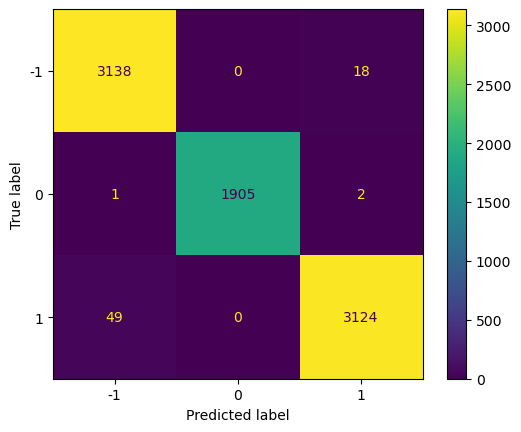

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale')  # Try 'rbf' or 'poly' as well
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()

In [6]:
import joblib

# Save the trained model to a file
joblib.dump(svm_classifier, 'svm_chess_model_test.pkl')

print("Model saved successfully!")


Model saved successfully!


In [ ]:
#MLP

import numpy as np
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Assuming you've already run the augmentation code, and your augmented dataset is in X_augmented, y_augmented

# Check the new label distribution
print(Counter(y_augmented))

# Normalize the features (important for neural networks)
scaler = StandardScaler()
X_augmented = scaler.fit_transform(X_augmented)

# Convert the labels to one-hot encoding for classification
y_augmented = to_categorical(y_augmented, num_classes=3)  # Assuming 3 classes: -1, 0, 1

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Build MLP model
model = Sequential()

# Input layer (Flatten the 1D feature vector into a single vector)
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))  # Input shape should match the number of features (1296)
model.add(Dropout(0.5))  # Dropout layer for regularization

# Hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer (for 3 classes)
model.add(Dense(3, activation='softmax'))  # 3 classes: -1, 0, 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save the model
model.save("chess_model_mlp.h5")
print("Model saved as chess_model_mlp.h5")

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions and labels back to single class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()


In [23]:
import cv2
import os

# Paths
base_dir = "./chess_images/board_and_fen"
output_dir = "output_with_fen"
os.makedirs(output_dir, exist_ok=True)

# Chessboard parameters
board_size = 480
square_size = board_size // 8

# Function to read FEN file and convert to 8x8 array
def read_fen_file(fen_file_path):
    with open(fen_file_path, 'r') as file:
        fen_content = file.read().strip()

    # Convert FEN string into an 8x8 list of squares
    fen_rows = fen_content.split('/')
    board = []
    for row in fen_rows:
        expanded_row = []
        for char in row:
            if char.isdigit():
                expanded_row.extend([''] * int(char))
            else:
                expanded_row.append(char)
        board.append(expanded_row)
    return board

# Overlay text on the image
def overlay_fen_on_image(image, board):
    for i in range(8):
        for j in range(8):
            piece = board[i][j]
            if piece:
                color = (0, 0, 255) if piece == 'b' else (255, 255, 255)  # Red for black, White for white
                text_position = (j * square_size + 20, i * square_size + 40)
                cv2.putText(image, piece, text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return image

# Process each folder 0-54
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    # Read FEN file
    fen_file_path = os.path.join(folder_path, "bw_board.fen")
    if not os.path.exists(fen_file_path):
        print(f"FEN file not found in {folder}")
        continue

    board = read_fen_file(fen_file_path)

    # Read one image (you can customize this to pick a specific image if needed)
    image_path = None
    for file in os.listdir(folder_path):
        if file.endswith(('.jpg', '.png')):
            image_path = os.path.join(folder_path, file)
            break

    if image_path is None:
        print(f"No image found in {folder}")
        continue

    # Read and resize image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (board_size, board_size))

    # Overlay FEN text
    image_with_fen = overlay_fen_on_image(image, board)

    # Save output
    output_path = os.path.join(output_dir, f"{folder}.jpg")
    cv2.imwrite(output_path, image_with_fen)

print("Overlay process completed.")


Overlay process completed.


In [2]:
import cv2
import os
import numpy as np
import random

# Augmentation functions
def adjust_brightness(img, factor=0.2):
    """Adjust brightness of the image."""
    return cv2.convertScaleAbs(img, alpha=1, beta=random.uniform(-factor*255, factor*255))

def add_gaussian_noise(img, mean=0, std=10):
    """Add Gaussian noise to the image."""
    noise = np.random.normal(mean, std, img.shape).astype(np.int16)
    noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)
    return noisy_img

def adjust_contrast(img, factor_range=(0.8, 1.2)):
    """Adjust contrast of the image."""
    factor = random.uniform(*factor_range)
    mean = np.mean(img)
    return np.clip((img - mean) * factor + mean, 0, 255).astype(np.uint8)

def color_jitter(img, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    """Randomly change the color properties (brightness, contrast, saturation, hue)."""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Adjust Hue
    hsv[..., 0] = np.clip(hsv[..., 0] + random.uniform(-hue, hue) * 255, 0, 255)

    # Adjust Saturation
    hsv[..., 1] = np.clip(hsv[..., 1] * random.uniform(1 - saturation, 1 + saturation), 0, 255)

    # Adjust Value (Brightness)
    hsv[..., 2] = np.clip(hsv[..., 2] * random.uniform(1 - brightness, 1 + brightness), 0, 255)

    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Adjust contrast by scaling the pixels
    img = cv2.convertScaleAbs(img, alpha=random.uniform(1 - contrast, 1 + contrast), beta=0)

    return img

# Paths
input_folder = 'processed_images'  # Source folder (original data)
output_folder = 'board_and_fen_augmented'     # Target folder (augmented data)

# Create output folder if not exists
os.makedirs(output_folder, exist_ok=True)

for i in range(55):
    input_folder_path = os.path.join(input_folder, str(i))
    output_folder_path = os.path.join(output_folder, str(i))

    if not os.path.exists(input_folder_path):
        print(f"Skipping folder {i} (does not exist)")
        continue

    os.makedirs(output_folder_path, exist_ok=True)

    images = sorted([f for f in os.listdir(input_folder_path) if f.endswith('.jpg') or f.endswith('.png')])

    if len(images) < 1:
        print(f"Folder {i} has no images — skipping.")
        continue

    # Load the first image
    original_image_path = os.path.join(input_folder_path, images[0])
    img = cv2.imread(original_image_path)

    # Generate 20 images using different augmentations
    for j in range(20):
        augmented = img.copy()

        # Apply random augmentations
        if random.random() > 0.5:
            augmented = adjust_brightness(augmented)
        if random.random() > 0.5:
            augmented = add_gaussian_noise(augmented)
        if random.random() > 0.5:
            augmented = adjust_contrast(augmented)
        if random.random() > 0.5:
            augmented = color_jitter(augmented)

        # Save the augmented image
        augmented_image_path = os.path.join(output_folder_path, f"augmented_{j+1}.jpg")
        cv2.imwrite(augmented_image_path, augmented)

    # Copy the bw_board.fen file directly (if exists)
    fen_file_path = os.path.join(input_folder_path, 'bw_board.fen')
    if os.path.exists(fen_file_path):
        output_fen_file_path = os.path.join(output_folder_path, 'bw_board.fen')
        with open(fen_file_path, 'r') as src, open(output_fen_file_path, 'w') as dst:
            dst.write(src.read())

print("Augmentation process complete.")


Augmentation process complete.


In [2]:
#5 images augumentation (main)

import cv2
import os
import numpy as np
import random

# Augmentation functions
def adjust_brightness(img, factor=0.2):
    return cv2.convertScaleAbs(img, alpha=1, beta=random.uniform(-factor * 255, factor * 255))

def add_gaussian_noise(img, mean=0, std=10):
    noise = np.random.normal(mean, std, img.shape).astype(np.int16)
    return np.clip(img + noise, 0, 255).astype(np.uint8)

def adjust_contrast(img, factor_range=(0.8, 1.2)):
    factor = random.uniform(*factor_range)
    mean = np.mean(img)
    return np.clip((img - mean) * factor + mean, 0, 255).astype(np.uint8)

def color_jitter(img, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[..., 0] = np.clip(hsv[..., 0] + random.uniform(-hue, hue) * 255, 0, 255)
    hsv[..., 1] = np.clip(hsv[..., 1] * random.uniform(1 - saturation, 1 + saturation), 0, 255)
    hsv[..., 2] = np.clip(hsv[..., 2] * random.uniform(1 - brightness, 1 + brightness), 0, 255)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return cv2.convertScaleAbs(img, alpha=random.uniform(1 - contrast, 1 + contrast), beta=0)

# Paths
input_folder = './chess_images/board_and_fen'
output_folder = './augumented_train_images/board_and_fen_train_50images'

os.makedirs(output_folder, exist_ok=True)

for i in range(0, 101):  # Loop through 20 subfolders
    input_folder_path = os.path.join(input_folder, str(i))
    output_folder_path = os.path.join(output_folder, str(i))

    if not os.path.exists(input_folder_path):
        print(f"Skipping folder {i} (does not exist)")
        continue

    os.makedirs(output_folder_path, exist_ok=True)

    images = sorted([f for f in os.listdir(input_folder_path) if f.endswith('.jpg') or f.endswith('.png')])

    if len(images) != 5:
        print(f"Folder {i} does not contain exactly 5 images — skipping.")
        continue

    # Process each of the 5 images
    for img_index, image_name in enumerate(images):
        original_image_path = os.path.join(input_folder_path, image_name)
        img = cv2.imread(original_image_path)

        # Save the original image directly
        cv2.imwrite(os.path.join(output_folder_path, image_name), img)

        # Generate 4 augmented versions per image
        for j in range(9):
            augmented = img.copy()

            # Apply random augmentations (you can customize this part)
            if random.random() > 0.5:
                augmented = adjust_brightness(augmented)
            if random.random() > 0.5:
                augmented = add_gaussian_noise(augmented)
            if random.random() > 0.5:
                augmented = adjust_contrast(augmented)
            if random.random() > 0.5:
                augmented = color_jitter(augmented)

            augmented_image_path = os.path.join(output_folder_path, f"{image_name.split('.')[0]}_augmented_{j+1}.jpg")
            cv2.imwrite(augmented_image_path, augmented)

    # Copy the bw_board.fen file if it exists
    fen_file_path = os.path.join(input_folder_path, 'bw_board.fen')
    if os.path.exists(fen_file_path):
        output_fen_file_path = os.path.join(output_folder_path, 'bw_board.fen')
        with open(fen_file_path, 'r') as src, open(output_fen_file_path, 'w') as dst:
            dst.write(src.read())

print("Augmentation process complete.")


Augmentation process complete.


In [10]:
import os
import shutil
import random

source_folder = './chess_images/board_and_fen'
target_folder = 'processed_images'

# Create target folder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

for folder_num in range(55):
    src_folder = os.path.join(source_folder, str(folder_num))
    dst_folder = os.path.join(target_folder, str(folder_num))

    os.makedirs(dst_folder, exist_ok=True)

    images = [f for f in os.listdir(src_folder) if f.endswith(('.jpg', '.png'))]

    if not images:
        print(f"No images found in folder {folder_num}")
        continue

    # Choose 1 image (can do random.choice or just take the first)
    selected_image = random.choice(images)  # or images[0] if you prefer fixed order
    shutil.copy2(os.path.join(src_folder, selected_image), os.path.join(dst_folder, selected_image))

    # Copy the bw_board.fen file too
    fen_file = os.path.join(src_folder, 'bw_board.fen')
    if os.path.exists(fen_file):
        shutil.copy2(fen_file, os.path.join(dst_folder, 'bw_board.fen'))
    else:
        print(f"No FEN file found in folder {folder_num}")

print("✅ Process completed — images and FEN files copied to 'processed_images/'")


✅ Process completed — images and FEN files copied to 'processed_images/'
